# This notebook shows how to fit a linear resonator in the shunt-coupled (or "hanger") configuration.

In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from resonator import background, see, shunt

Create data using the model plus gaussian noise. The model is the product of the shunt resonator model and a background model, which in this case has a tilt in magnitude and a typical value of the cable delay.

In [2]:
# Background parameters
background_model = background.MagnitudeSlopeOffsetPhaseDelay()
magnitude_slope = -1e-8
magnitude_offset = 0.1
phase = -np.pi / 2
delay = 80e-9  # frequency is in Hz, so this is in s

# Foreground parameters
foreground_model = shunt.LinearShunt()
f_r = 1e9  # resonance frequency
df = 2e6  # frequency width
f = np.linspace(f_r - df / 2, f_r + df / 2, 501)
internal_loss = 5e-5  # Q_i = 20 000
coupling_loss = 5e-5  # Q_c = 20 000
asymmetry = 0.2  # causes rotation and expansion of the resonance circle due to impedance mismatch or parasitic coupling

# Create the data by evaluating the model functions with the given parameters
bg = background_model.func(frequency=f, frequency_reference=f.min(), phase=phase, delay=delay,
                           magnitude_slope=magnitude_slope, magnitude_offset=magnitude_offset)
fg = foreground_model.func(frequency=f, resonance_frequency=f_r, internal_loss=internal_loss, coupling_loss=coupling_loss,
                           asymmetry=asymmetry)

# The ideal data is the product of the background and foreground.
s21 = bg * fg

# The measured data will include noise
noise = 0.01 * magnitude_offset
s21n = s21 + noise * (np.random.randn(s21.size) + 1j * np.random.randn(s21.size))

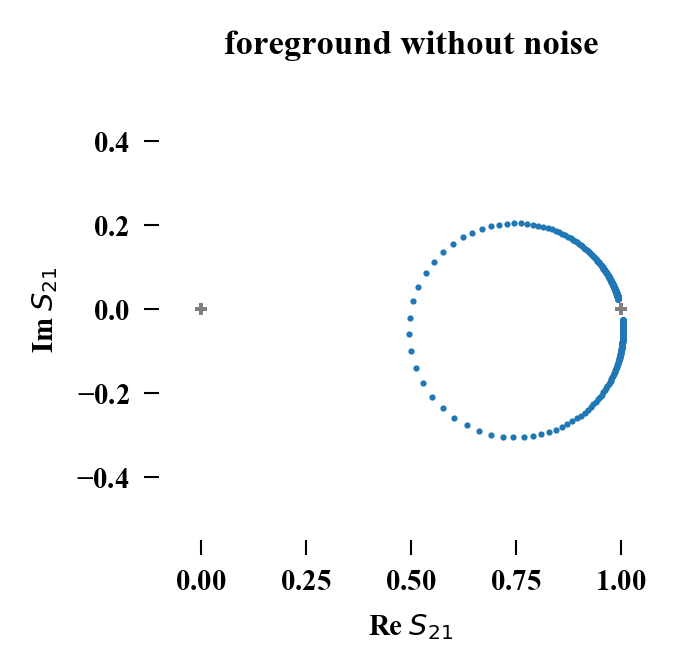

In [3]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(fg.real, fg.imag, '.')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.55, 0.55);
ax.plot([0, 1], [0, 0], marker='P', linestyle='none', color='gray')
ax.set_title('foreground without noise');

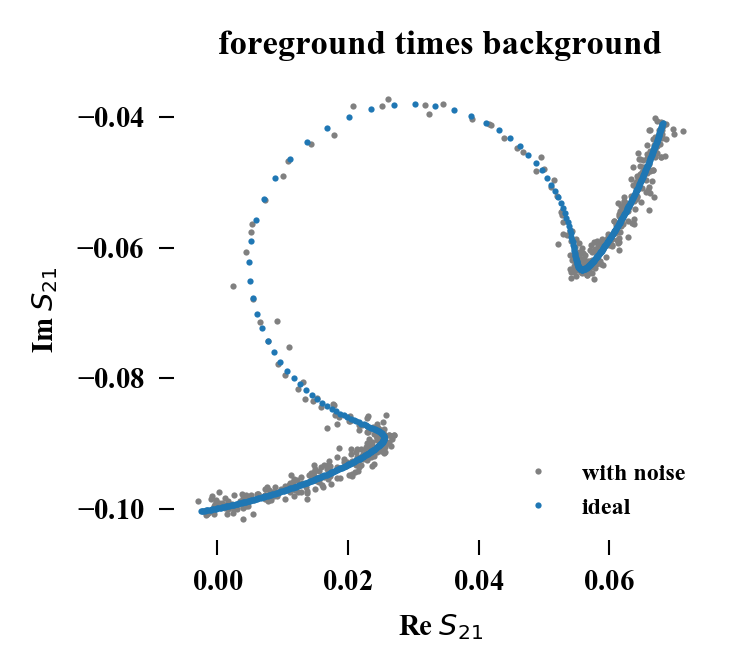

In [4]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(s21n.real, s21n.imag, '.', color='gray', label='with noise')
ax.plot(s21.real, s21.imag, '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

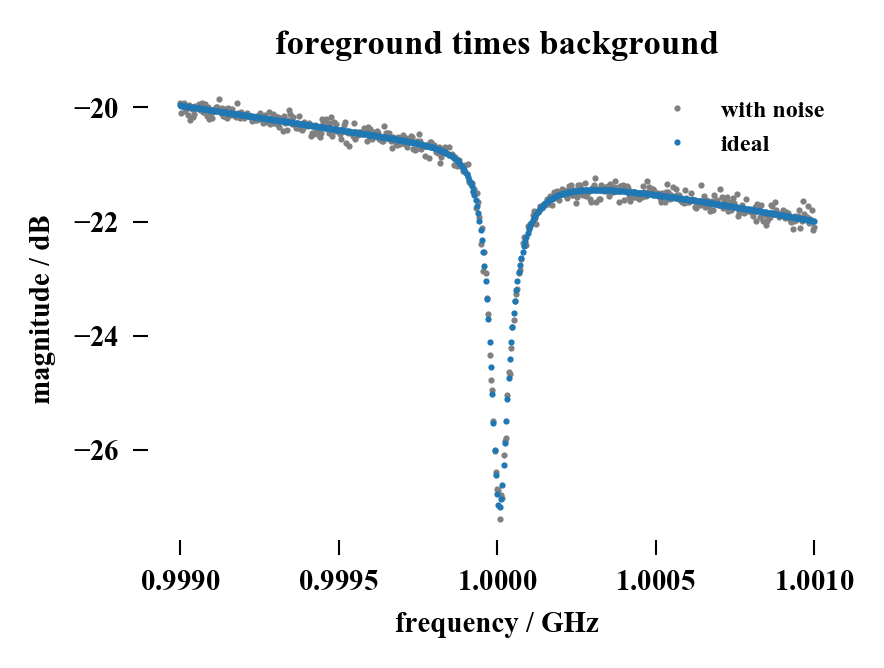

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('magnitude / dB')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21n)), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21)), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

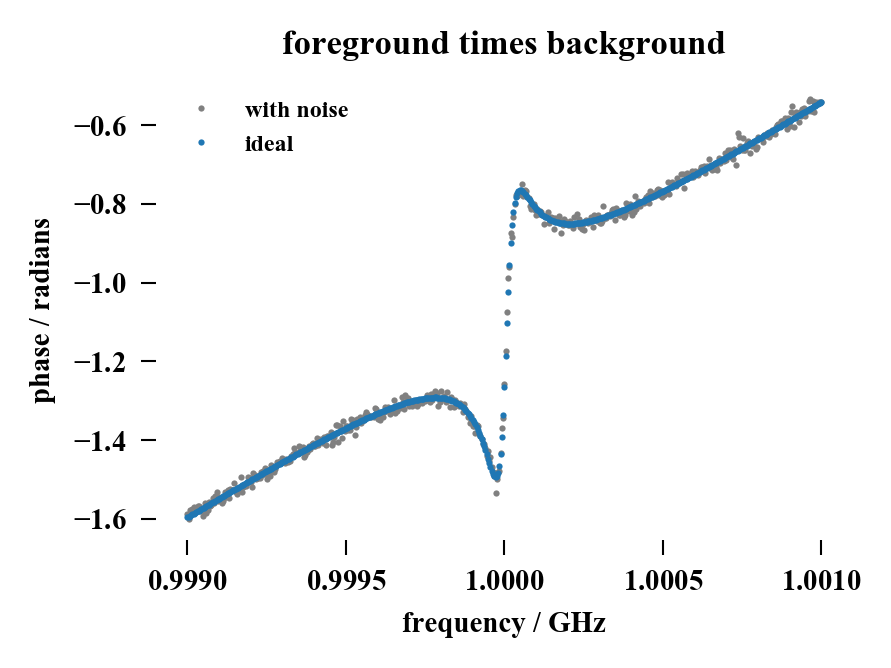

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('phase / radians')
ax.plot(1e-9 * f, np.angle(s21n), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, np.angle(s21), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

## Fit the model to the data using a LinearShuntFitter.

Note that the default background model (`background.ComplexConstant`) will not work well here because the background has too much structure.

Here, we know the standard error of each data point because we added the noise. If no errors are given, the fitting assumes equal errors for each point and thus equal weights, so errors are not generally necessary unless they vary between points.

In [7]:
resonator = shunt.LinearShuntFitter(frequency=f, data=s21n, errors=(1 + 1j) * noise * np.ones(f.size),
                              background_model=background.MagnitudeSlopeOffsetPhaseDelay())
print(resonator.result.fit_report())  # result is a lmfit.model.ModelResult object

[[Model]]
    (Model(magnitude_slope_offset_phase_delay) * Model(linear_shunt))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 1002
    # variables        = 8
    chi-square         = 971.137427
    reduced chi-square = 0.97699942
    Akaike info crit   = -15.3478627
    Bayesian info crit = 23.9301636
[[Variables]]
    frequency_reference:  1e+09 (fixed)
    magnitude_slope:     -9.8211e-09 +/- 8.4004e-11 (0.86%) (init = -1.110586e-08)
    magnitude_offset:     0.08998951 +/- 4.8279e-05 (0.05%) (init = 0.08712876)
    phase:               -1.06785575 +/- 5.4028e-04 (0.05%) (init = -1.075724)
    delay:                8.0068e-08 +/- 1.4918e-10 (0.19%) (init = 9.12851e-08)
    resonance_frequency:  1.0000e+09 +/- 385.605824 (0.00%) (init = 1.000008e+09)
    internal_loss:        5.0198e-05 +/- 5.7572e-07 (1.15%) (init = 3.40688e-05)
    coupling_loss:        5.0006e-05 +/- 2.9462e-07 (0.59%) (init = 3.393066e-05)
    asymmetry:  

## How well do the fit values match the actual values, given the fit standard errors?

In [8]:
print("Normalized deviations: |fit_value - true_value| / fit_standard_error")
print("f_r: {:.2f}".format(abs(resonator.f_r - f_r) / resonator.f_r_error))
print("Q_c: {:.2f}".format(abs(resonator.Q_c - 1 / coupling_loss) / resonator.Q_c_error))
print("Q_i: {:.2f}".format(abs(resonator.Q_i - 1 / internal_loss) / resonator.Q_i_error))
print("asymmetry: {:.2f}".format(abs(resonator.asymmetry - asymmetry) / resonator.asymmetry_error))
print("magnitude_offset: {:.2f}".format(abs(resonator.magnitude_offset - magnitude_offset) / resonator.magnitude_offset_error))
print("magnitude_slope: {:.2f}".format(abs(resonator.magnitude_slope - magnitude_slope) / resonator.magnitude_slope_error))
print("delay: {:.2f}".format(abs(resonator.delay - delay) / resonator.delay_error))
print("phase: {:.2f}".format(abs(resonator.phase - phase) / resonator.phase_error))

Normalized deviations: |fit_value - true_value| / fit_standard_error
f_r: 1.00
Q_c: 0.02
Q_i: 0.35
asymmetry: 1.27
magnitude_offset: 207.34
magnitude_slope: 2.13
delay: 0.45
phase: 930.90


## Plot the data

Use the `see.py` fitting module to plot the data, model, and resonance.

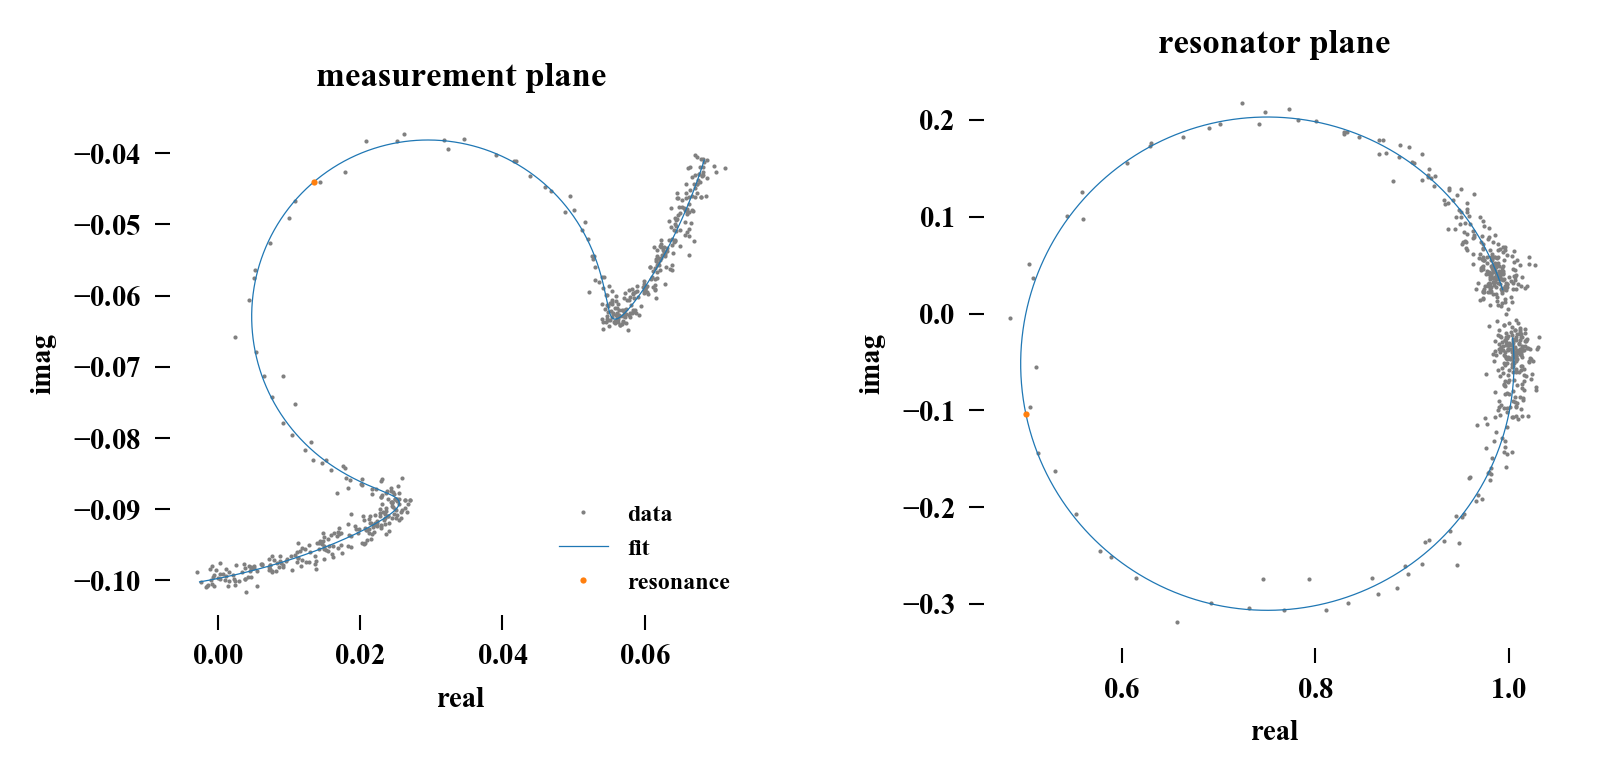

In [9]:
fig, (ax_raw, ax_norm) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)  # Adjust these values for your plot settings
ax_raw.set_title('measurement plane')
ax_norm.set_title('resonator plane')
see.real_and_imaginary(resonator=resonator, axes=ax_raw, normalize=False)
see.real_and_imaginary(resonator=resonator, axes=ax_norm, normalize=True)
ax_raw.legend(handles=ax_raw.lines, labels=('data', 'fit', 'resonance'), fontsize='xx-small');

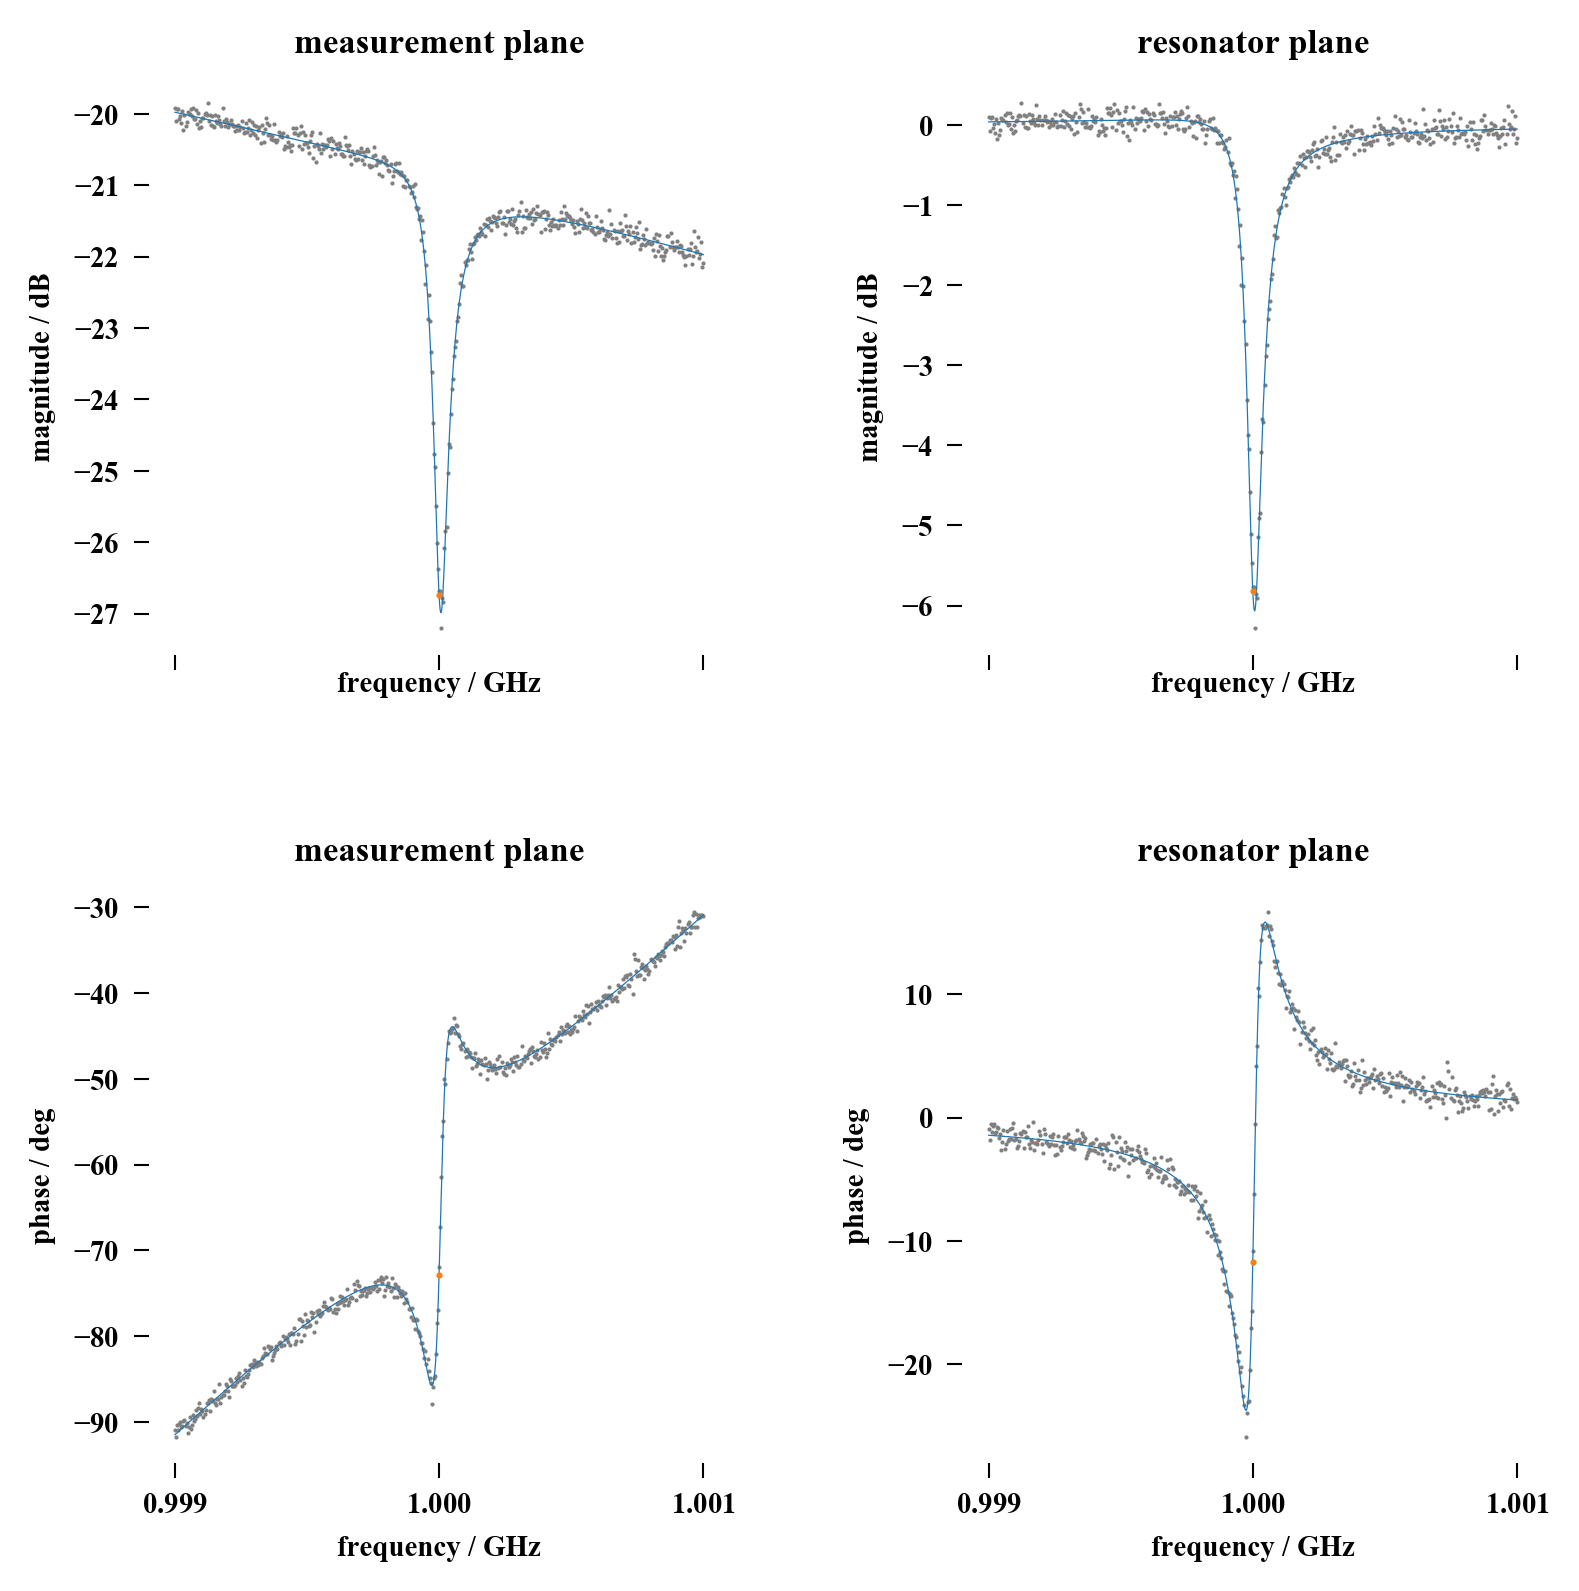

In [10]:
fig, axes = plt.subplots(2, 2, sharex='all', figsize=(6, 6), dpi=300)  # Adjust these values for your plot settings
ax_raw_mag, ax_norm_mag, ax_raw_phase, ax_norm_phase = axes.flatten()
ax_raw_mag.set_title('measurement plane')
ax_norm_mag.set_title('resonator plane')
ax_raw_phase.set_title('measurement plane')
ax_norm_phase.set_title('resonator plane')
see.magnitude_vs_frequency(resonator=resonator, axes=ax_raw_mag, normalize=False, frequency_scale=1e-9)
see.magnitude_vs_frequency(resonator=resonator, axes=ax_norm_mag, normalize=True, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_raw_phase, normalize=False, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_norm_phase, normalize=True, frequency_scale=1e-9);